
Visualize posterior and optimized prior covariance matrix for a classification model. Model: 1-layer neural network. Dataset: on your choice (synthetic dataset is allowed). Use normal distribution with diagonal covariance prior. For posterior distribution use Laplace approximation.

## Theory

Consider the following setup of binary classification. The measured data consist of measured data of a dependent variable $y$ and
an independent variable $x$. 

Object $y$ is distributed as $Bern(\mu (x))$. Assume that $\mu(x) = \sigma(f(x))$, where $f$ is 1-layer neural network.

Additionally we set prior distribution over parameters $w$ of $f$, that is
$$p(w|A) = \mathcal N (w | 0, A^{-1}),\; A = diag(\alpha_1, \dots, \alpha_d).$$

The first level of Bayesian inference estimates $w$ by maximizing posterior
distribution
$$p(w | X, Y, A) \propto p(w | A) p(Y|X, w).$$
It is more convenient to maximize logarithm of this value, i.e.
$$\log p(w | X, Y, A) \propto -\frac{1}{2} w^T A w  + \sum \limits_{i=1}^{N} [Y_i \log \sigma(f(X_i)) + (1 -Y_i) \log (1 - \sigma(f(X_i)))],$$
$$w_0 = \text{argmax} \log p(w | X, Y, A).$$

The second level of the bayesian inference selects the best model from the
set of competitive models by maximizing a posterior probability
$$p(A|X, Y) \propto_A p(A)P(Y|X, A) \propto_A P(Y|X, A).$$
By http://strijov.com/papers/HyperOptimizationEng.pdf we have
$$P(Y|X, A) = \int p(Y|X, w) p(w|A) \text d w \approx e^{S(w_0)} \frac{(2\pi)^{d/2}}{(\det H)^{1/2}},$$
where
$$S(w) = \log p(Y|X, w) p(w|A) =\log p(Y|X, w) -\frac{d}{2} \log 2\pi + \frac{1}{2} \log \det A -\frac{1}{2} w^T A w,$$
$$H = -\nabla \nabla S(w) |_{w_0} = -\nabla \nabla \log p(Y|X, w) |_{w_0} + A.$$
Then 
$$g(A) = \log \left(e^{S(w_0)} \frac{(2\pi)^{d/2}}{(\det H)^{1/2}}\right) \propto_A \frac{1}{2} \log \det A -\frac{1}{2} w_0^T A w_0 -\frac{1}{2} \log \det H \rightarrow max$$
Let $h_1, \dots, h_d$ be eigenvalues of $H_D = -\nabla \nabla \log p(Y|X, w) |_{w_0}$. The update rule for A is
$$\alpha_j = \frac{h_j}{2} \left(-1 + \sqrt{1 + \frac{4}{h_j ||w_0||^2}} \right).$$

The values of $H_D$ can be approximated as
$$H_D \approx \frac{1}{n} \sum (\nabla_w \log p(Y_i | X_i, w))(\nabla_w \log p(Y_i | X_i, w))^T \approx \frac{1}{n} \text{diag} \sum (\nabla_w \log p(Y_i | X_i, w))^2.$$

Remark that $H$ is an approximation of a posterior covariance matrix.

If the prior distribution is 
$$p(w|A) = \mathcal N (w | m, A^{-1}),\; A = diag(\alpha_1, \dots, \alpha_d),$$
then the update rule is 
$$\alpha_j = \frac{h_j}{2} \left(-1 + \sqrt{1 + \frac{4}{h_j ||w_0 - m||^2}} \right),$$
$$m = w_0.$$


## Experiments

In [33]:
import torch
from torch import nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output
import numpy as np
import sklearn.linear_model
import seaborn as sns

Start with an easy dataset of blobs

In [203]:
dataset_x, dataset_y = datasets.make_blobs(1000, centers=2)
dataset_x = (dataset_x - dataset_x.mean()) / dataset_x.std()

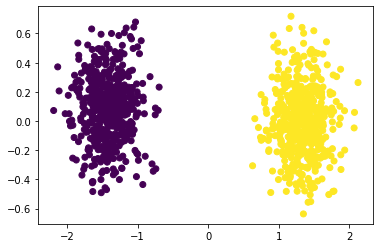

In [132]:
plt.scatter(dataset_x[:, 0], dataset_x[:, 1], c=dataset_y);

Divide it into train and validation

In [204]:
X_train, X_test, y_train, y_test = train_test_split(torch.Tensor(dataset_x), torch.Tensor(dataset_y), test_size=0.3, random_state=42)

Let's check the accuracy of a linear classifier on this data

In [206]:
linear_model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
np.mean((linear_model.predict(X_test) > 0)*1. == np.array(y_test))

0.7666666666666667

Prepare datasets for training

In [168]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [169]:
class SimpleNet(nn.Module):
  def __init__(self, input_dim=30, hidden_dim=16):
    """
    simple 1-layer net
    """
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 1)
    )

  def forward(self, x):
    return self.layers(x)

In [181]:
class LaplaceApproximation():
  def __init__(self, model):
    '''
    this class implements loss and prior update rule
    '''
    self.model = model

    #number of model parameters (d)
    self.params_num = sum([torch.numel(p) for p in self.model.parameters()])
    
    #diagonal of the inverse of prior covariance (diag(A))
    self.diag = torch.ones(self.params_num, requires_grad=False)
    #self.diag = torch.rand(self.params_num, requires_grad=False)

    #prior mean (m)
    self.mean = torch.zeros(self.params_num, requires_grad=False)

    self.sigmoid = nn.Sigmoid()

  def log_likelihood(self, x, y):
    """
    implementation of log likelihood (second part of loss function)
    """
    probs = self.sigmoid(self.model(x))
    return torch.mean(torch.log(1 - probs + 1e-8) * (1 - y) + torch.log(probs + 1e-8) * y) #* self.data_size

  def log_prior(self):
    """
    implementation of log prior (first part of loss function)
    """
    weights = torch.cat([torch.flatten(p) for p in self.model.parameters()])
    return -0.5 * self.diag @ ((weights - self.mean)**2)

  def loss(self, x, y):
    """
    loss -- minus log of posterior distribution
    """
    return -self.log_prior() - self.log_likelihood(x, y)

  def compute_Hd(self, x, y):
    """
    approximation of Hd
    """
    Hd = torch.zeros(self.params_num)
    for i in range(x.shape[0]):
      for param in self.model.parameters():
        param.grad = torch.zeros_like(param)

      log_loss = self.log_likelihood(x[i:i+1], y[i:i+1])
      log_loss.backward()
      Hd += torch.cat([torch.flatten(p.grad)**2 for p in self.model.parameters()])

    
    Hd /= x.shape[0] 
    return Hd

  def update_prior(self, x, y):
    """
    updates mean and covariance of prior distribution
    """
    weights = torch.cat([torch.flatten(p) for p in self.model.parameters()])
    w_norm = torch.linalg.norm(weights - self.mean)

    Hd = self.compute_Hd(x, y)
    self.diag = ((torch.sqrt(1 + 4 / (Hd * w_norm + 1e-8))-1)*Hd/2).detach()
    self.mean = weights.detach()
  
  def get_posterior_covariance(self, x, y):
    """
    computes Laplace approximation of posterior covariance
    """
    Hd = torch.zeros((self.params_num, self.params_num))
    for i in range(x.shape[0]):
      for param in self.model.parameters():
        param.grad = torch.zeros_like(param)

      log_loss = self.log_likelihood(x[i:i+1], y[i:i+1])
      log_loss.backward()

      grads = torch.cat([torch.flatten(p.grad) for p in self.model.parameters()])
      Hd += grads.reshape(-1, 1) @ grads.reshape(1, -1)

    
    Hd /= x.shape[0] 

    H = torch.diag(self.diag) + Hd
    return H


In [ ]:
net = SimpleNet(2, 10)
la = LaplaceApproximation(net)
prior_diag = la.diag
optimizer = torch.optim.Adam(params=la.model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [193]:
num_epochs = 200

In [206]:
losses = []
val_accuracy = []
train_accuracy = []
priors = []
for epoch in range(num_epochs):
  #first level of Bayesian inference
  la.model.train()
  for x, y in train_loader:
    optimizer.zero_grad()
    loss = la.loss(x, y)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
  scheduler.step()

  la.model.eval()
  #second level of Bayesian inference
  if epoch % 20 == 9:
    la.update_prior(X_train, y_train)
    priors.append(np.array(la.diag))

  #compute metrics
  correct = 0
  correct_train = 0
  with torch.no_grad():
    for x, y in test_loader:
      output = la.model(x)
      correct += torch.sum((output.reshape(-1) > 0) == y)
    for x, y in train_loader:
      output = la.model(x)
      correct_train += torch.sum((output.reshape(-1) > 0) == y)
      
  val_accuracy.append(correct/len(test_dataset))
  train_accuracy.append(correct_train/len(train_dataset))

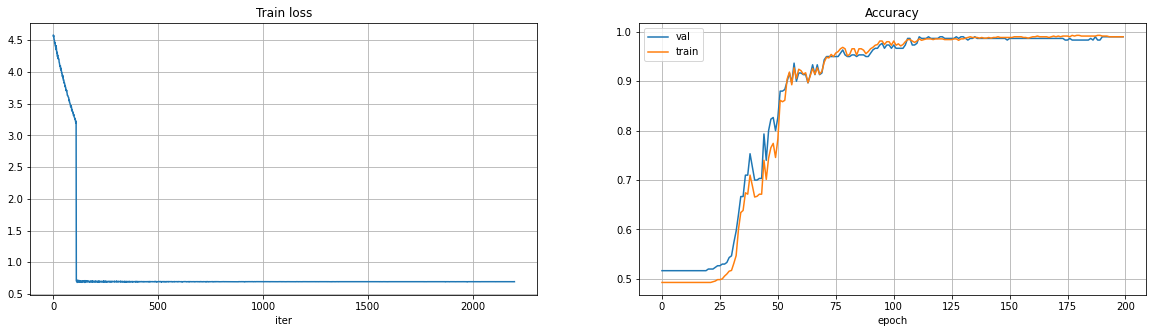

In [145]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(losses)
plt.xlabel('iter')
plt.title('Train loss')

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(val_accuracy, label='val')
plt.plot(train_accuracy, label='train')
plt.xlabel('epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
priors = np.array(priors)

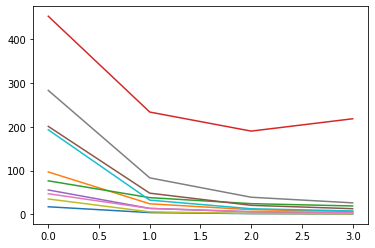

In [ ]:
for i in range(len(priors)):
  plt.plot(1 / priors[:4, i])

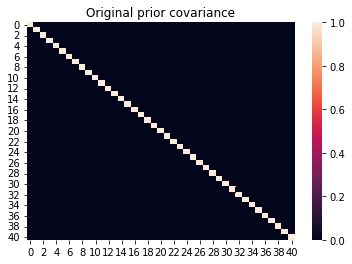

In [ ]:
sns.heatmap(np.diag(prior_diag))
plt.title('Original prior covariance')
plt.show()

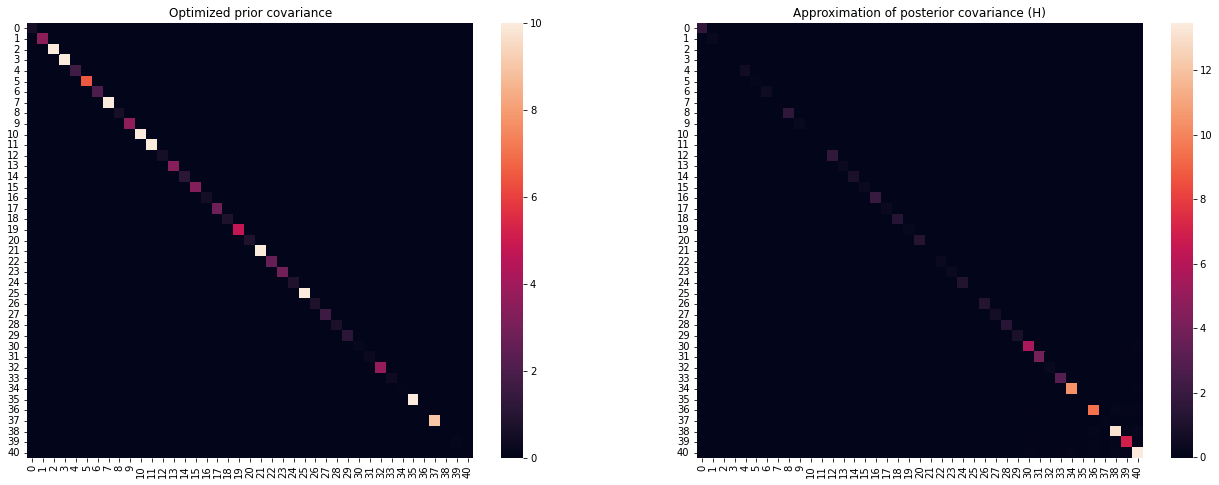

In [ ]:
plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
sns.heatmap(np.diag(1 / (priors[-1] + 1e-8)), vmax=10)
plt.title('Optimized prior covariance')
plt.subplot(1, 2, 2)
H = la.get_posterior_covariance(X_train, y_train)
#H = la.compute_Hd(X_train, y_train) + la.diag
sns.heatmap(H)
plt.title('Approximation of posterior covariance (H)')
plt.show()

### Other dataset

In [ ]:
dataset = datasets.load_breast_cancer()

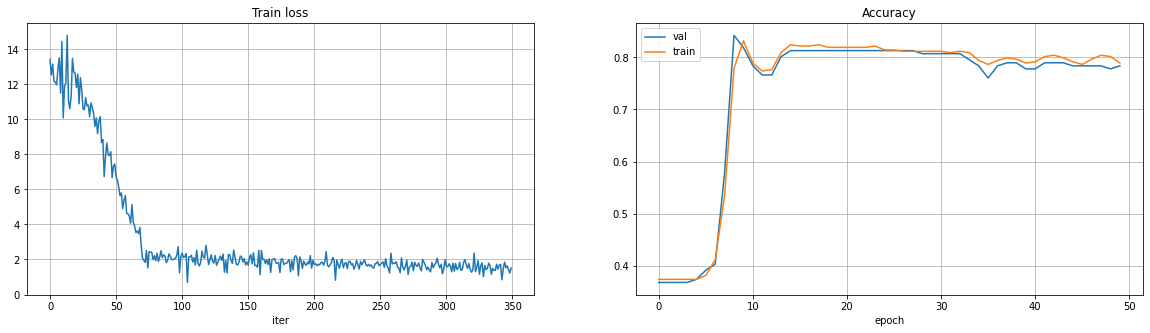

In [196]:
#cancer
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(losses)

plt.xlabel('iter')
plt.title('Train loss')
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(val_accuracy, label='val')
plt.plot(train_accuracy, label='train')

plt.xlabel('epoch')
plt.title('Accuracy')
plt.legend()
plt.show()

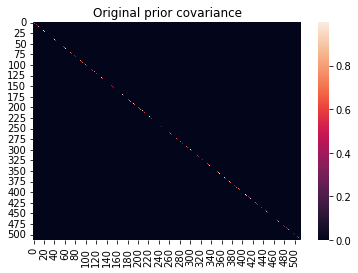

In [197]:
sns.heatmap(np.diag(prior_diag))
plt.title('Original prior covariance')
plt.show()

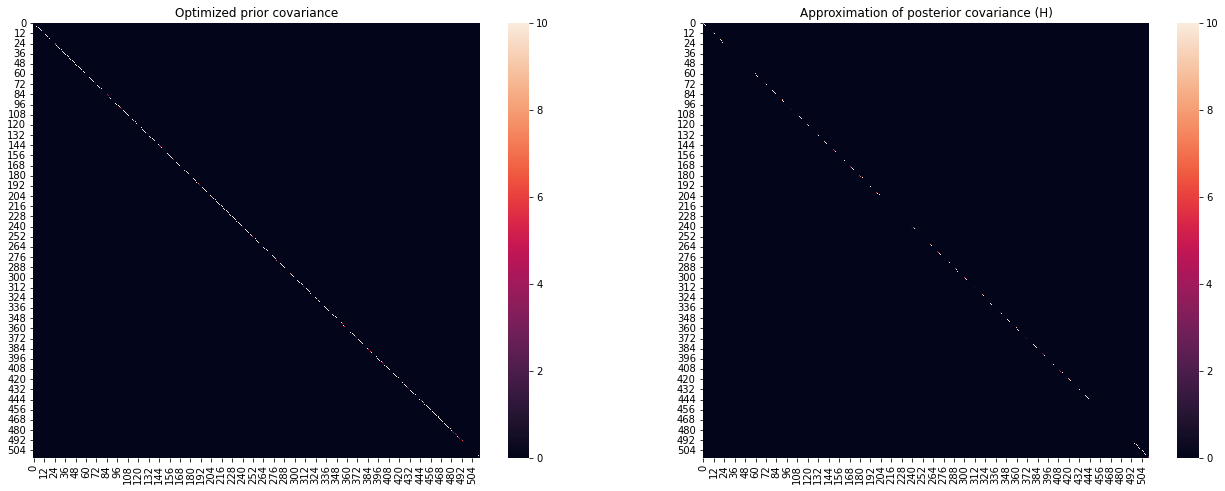

In [202]:
plt.figure(figsize=(22, 8))
plt.subplot(1, 2, 1)
sns.heatmap(np.diag(1 / (priors[-1] + 1e-8)), vmax=10)
plt.title('Optimized prior covariance')
plt.subplot(1, 2, 2)
#H = la.get_posterior_covariance(X_train, y_train)
H = la.compute_Hd(X_train, y_train) + la.diag
sns.heatmap(np.diag(H), vmax=10)
plt.title('Approximation of posterior covariance (H)')
plt.show()